# Test transformers implementation in Jax/Equinox

In [1]:
import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
####################
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
######################################################

In [2]:
%matplotlib inline

## Standard libraries
import os
import numpy as np
import math
import json
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.auto import tqdm

## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random
# Seeding for random operations
main_rng = random.PRNGKey(42)

## Flax (NN in JAX)
import flax
from flax import linen as nn
from flax.training import train_state

import equinox as eqx

import jax.tree_util as jtu
from math import prod

## Optax (Optimizers in JAX)
import optax

# Torch
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter

# load data
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../../data/torchvision"

# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../data/torchvision/saved_models/tutorial15_jax"

In [3]:
def count_params(params):
    param_numbers = jtu.tree_map(lambda x: prod(x.shape), params)
    vals, _ = jtu.tree_flatten(param_numbers)
    return sum(vals)

In [4]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.shape[-1]
    attn_logits = jnp.matmul(q, jnp.swapaxes(k, -2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = jnp.where(mask == 0, -9e15, attn_logits)
    attention = nn.softmax(attn_logits, axis=-1)
    values = jnp.matmul(attention, v)
    return values, attention

In [5]:
seq_len, d_k = 3, 2
main_rng, rand1 = random.split(main_rng)
qkv = random.normal(rand1, (3, seq_len, d_k))
q, k, v = qkv[0], qkv[1], qkv[2]
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Q
 [[-0.6613315   0.70056266]
 [ 0.08239268 -1.7793142 ]
 [-0.04378588  1.0965251 ]]
K
 [[ 1.7257481   0.35568172]
 [ 1.3034704   1.2873708 ]
 [ 1.6871481  -0.5714404 ]]
V
 [[ 1.5129997   1.1050899 ]
 [ 0.27949408 -0.46224892]
 [-1.1003422  -1.1437942 ]]
Values
 [[ 0.376226   -0.14656176]
 [-0.42778552 -0.5989564 ]
 [ 0.43624765 -0.11678293]]
Attention
 [[0.27963293 0.54049295 0.17987415]
 [0.22194655 0.06706189 0.71099156]
 [0.27977088 0.58373076 0.13649833]]


In [6]:
# Helper function to support different mask shapes.
# Output shape supports (batch_size, number of heads, seq length, seq length)
# If 2D: broadcasted over batch size and number of heads
# If 3D: broadcasted over number of heads
# If 4D: leave as is
def expand_mask(mask):
    assert mask.ndim > 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

In [7]:
class MultiheadAttention(nn.Module):
    embed_dim : int  # Output dimension
    num_heads : int  # Number of parallel heads (h)

    def setup(self):
        # Stack all weight matrices 1...h and W^Q, W^K, W^V together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Dense(3*self.embed_dim,
                                 kernel_init=nn.initializers.xavier_uniform(),  # Weights with Xavier uniform init
                                 bias_init=nn.initializers.zeros  # Bias init with zeros
                                )
        self.o_proj = nn.Dense(self.embed_dim,
                               kernel_init=nn.initializers.xavier_uniform(),
                               bias_init=nn.initializers.zeros)

    def __call__(self, x, mask=None):
        batch_size, seq_length, embed_dim = x.shape
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, -1)
        qkv = qkv.transpose(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = jnp.array_split(qkv, 3, axis=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.transpose(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        return o, attention

In [8]:
## Test MultiheadAttention implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create attention
mh_attn = MultiheadAttention(embed_dim=128, num_heads=4)
# Initialize parameters of attention with random key and inputs
main_rng, init_rng = random.split(main_rng)
params = mh_attn.init(init_rng, x)['params']
print(count_params(params))
# Apply attention with parameters on the inputs
out, attn = mh_attn.apply({'params': params}, x)
print('Out', out.shape, 'Attention', attn.shape)

del mh_attn, params

66048
Out (3, 16, 128) Attention (3, 4, 16, 16)


In [9]:
class EncoderBlock(nn.Module):
    input_dim : int  # Input dimension is needed here since it is equal to the output dimension (residual connection)
    num_heads : int
    dim_feedforward : int
    dropout_prob : float
    use_norm: bool = True

    def setup(self):
        # Attention layer
        self.self_attn = MultiheadAttention(embed_dim=self.input_dim,
                                            num_heads=self.num_heads)
        # Two-layer MLP
        self.linear = [
            nn.Dense(self.dim_feedforward),
            nn.Dropout(self.dropout_prob),
            nn.relu,
            nn.Dense(self.input_dim)
        ]
        # Layers to apply in between the main layers
        if self.use_norm:
            self.norm1 = nn.LayerNorm()
            self.norm2 = nn.LayerNorm()
        self.dropout = nn.Dropout(self.dropout_prob)

    def __call__(self, x, mask=None, train=True):
        # Attention part
        attn_out, _ = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out, deterministic=not train)
        if self.use_norm:
            x = self.norm1(x)

        # MLP part
        linear_out = x
        for l in self.linear:
            linear_out = l(linear_out) if not isinstance(l, nn.Dropout) else l(linear_out, deterministic=not train)
        x = x + self.dropout(linear_out, deterministic=not train)
        if self.use_norm:
            x = self.norm2(x)

        return x

In [10]:
## Test EncoderBlock implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create encoder block
encblock = EncoderBlock(input_dim=128, num_heads=4, dim_feedforward=512, dropout_prob=0.1)
# Initialize parameters of encoder block with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = encblock.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']
print(count_params(params))
# Apply encoder block with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
out = encblock.apply({'params': params}, x, train=True, rngs={'dropout': dropout_apply_rng})
print('Out', out.shape)

del encblock, params

198272
Out (3, 16, 128)


In [11]:
class TransformerEncoder(nn.Module):
    num_layers : int
    input_dim : int
    num_heads : int
    dim_feedforward : int
    dropout_prob : float
    use_norm: bool = True

    def setup(self):
        self.layers = [EncoderBlock(self.input_dim, self.num_heads, self.dim_feedforward, self.dropout_prob, use_norm=self.use_norm) for _ in range(self.num_layers)]

    def __call__(self, x, mask=None, train=True):
        for l in self.layers:
            x = l(x, mask=mask, train=train)
        return x

    def get_attention_maps(self, x, mask=None, train=True):
        # A function to return the attention maps within the model for a single application
        # Used for visualization purpose later
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask)
            attention_maps.append(attn_map)
            x = l(x, mask=mask, train=train)
        return attention_maps

In [12]:
## Test TransformerEncoder implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create Transformer encoder
transenc = TransformerEncoder(num_layers=5,
                              input_dim=128,
                              num_heads=8,
                              dim_feedforward=256,
                              dropout_prob=0.15)
# Initialize parameters of transformer with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = transenc.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']
print(count_params(params))
# Apply transformer with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
# Instead of passing params and rngs every time to a function call, we can bind them to the module
binded_mod = transenc.bind({'params': params}, rngs={'dropout': dropout_apply_rng})
out = binded_mod(x, train=True)
print('Out', out.shape)
attn_maps = binded_mod.get_attention_maps(x, train=True)
print('Attention maps', len(attn_maps), attn_maps[0].shape)

del transenc, binded_mod, params

662400
Out (3, 16, 128)
Attention maps 5 (3, 8, 16, 16)


In [13]:
class PositionalEncoding(nn.Module):
    d_model : int         # Hidden dimensionality of the input.
    max_len : int = 5000  # Maximum length of a sequence to expect.

    def setup(self):
        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = np.zeros((self.max_len, self.d_model))
        position = np.arange(0, self.max_len, dtype=np.float32)[:,None]
        div_term = np.exp(np.arange(0, self.d_model, 2) * (-math.log(10000.0) / self.d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        pe = pe[None]
        self.pe = jax.device_put(pe)

    def __call__(self, x):
        x = x + self.pe[:, :x.shape[1]]
        return x

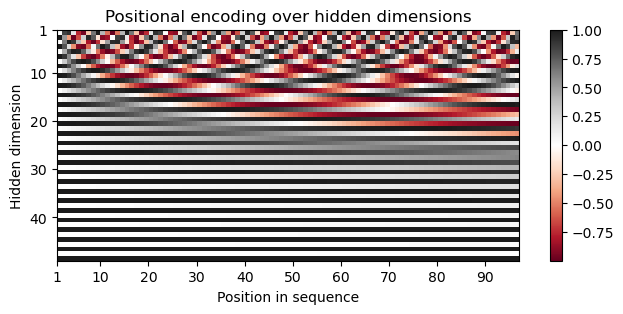

In [14]:
# Create encoding block, bind to access positional encoding (module has no parameters)
encod_block = PositionalEncoding(d_model=48, max_len=96).bind({})
# Obtain positional encodings as numpy array
pe = jax.device_get(encod_block.pe.squeeze().T)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

In [15]:
def cosine_warmup_schedule(base_lr: float, warmup: int, max_iters: int):
    assert warmup > 0 and max_iters > 0
    # Create function to return lr based on iteration count
    def get_lr(train_iter):
        lr_factor = 0.5 * (1 + np.cos(np.pi * train_iter / max_iters))
        if train_iter <= warmup:
            lr_factor *= train_iter * 1.0 / warmup
        return lr_factor * base_lr
    return get_lr

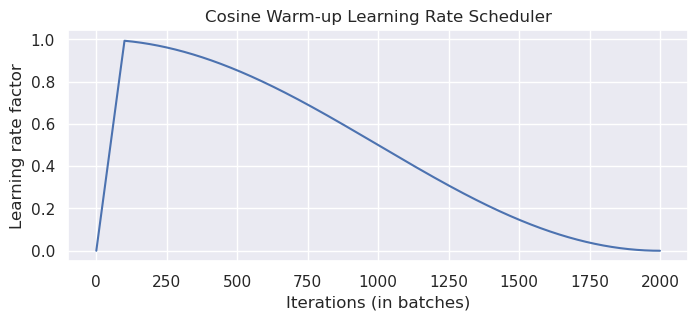

In [16]:
lr_scheduler = cosine_warmup_schedule(base_lr=1.0, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

In [17]:
class TransformerPredictor(nn.Module):
    model_dim : int                   # Hidden dimensionality to use inside the Transformer
    num_classes : int                 # Number of classes to predict per sequence element
    num_heads : int                   # Number of heads to use in the Multi-Head Attention blocks
    num_layers : int                  # Number of encoder blocks to use
    dropout_prob : float = 0.0        # Dropout to apply inside the model
    input_dropout_prob : float = 0.0  # Dropout to apply on the input features

    def setup(self):
        # Input dim -> Model dim
        self.input_dropout = nn.Dropout(self.input_dropout_prob)
        self.input_layer = nn.Dense(self.model_dim)
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(self.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.num_layers,
                                              input_dim=self.model_dim,
                                              dim_feedforward=2*self.model_dim,
                                              num_heads=self.num_heads,
                                              dropout_prob=self.dropout_prob)
        # Output classifier per sequence lement
        self.output_net = [
            nn.Dense(self.model_dim),
            nn.LayerNorm(),
            nn.relu,
            nn.Dropout(self.dropout_prob),
            nn.Dense(self.num_classes)
        ]

    def __call__(self, x, mask=None, add_positional_encoding=True, train=True):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
            train - If True, dropout is stochastic
        """
        x = self.input_dropout(x, deterministic=not train)
        x = self.input_layer(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask, train=train)
        for l in self.output_net:
            x = l(x) if not isinstance(l, nn.Dropout) else l(x, deterministic=not train)
        return x

    def get_attention_maps(self, x, mask=None, add_positional_encoding=True, train=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_dropout(x, deterministic=not train)
        x = self.input_layer(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask, train=train)
        return attention_maps

In [18]:
## Test TransformerPredictor implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 64))
# Create Transformer encoder
transpre = TransformerPredictor(num_layers=5,
                                model_dim=128,
                                num_classes=10,
                                num_heads=4,
                                dropout_prob=0.15,
                                input_dropout_prob=0.05)
# Initialize parameters of transformer predictor with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = transpre.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']
print(count_params(params))
# Apply transformer predictor with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
# Instead of passing params and rngs every time to a function call, we can bind them to the module
binded_mod = transpre.bind({'params': params}, rngs={'dropout': dropout_apply_rng})
out = binded_mod(x, train=True)
print('Out', out.shape)
attn_maps = binded_mod.get_attention_maps(x, train=True)
print('Attention maps', len(attn_maps), attn_maps[0].shape)

del transpre, binded_mod, params

688778
Out (3, 16, 10)
Attention maps 5 (3, 4, 16, 16)


In [19]:
class TrainerModule:

    def __init__(self, model_name, exmp_batch, max_iters, lr=1e-3, warmup=100, seed=42, **model_kwargs):
        """
        Inputs:
            model_name - Name of the model. Used for saving and checkpointing
            exmp_batch - Example batch to the model for initialization
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            seed - Seed to use for model init
        """
        super().__init__()
        self.model_name = model_name
        self.max_iters = max_iters
        self.lr = lr
        self.warmup = warmup
        self.seed = seed
        # Create empty model. Note: no parameters yet
        self.model = TransformerPredictor(**model_kwargs)

        #Prepare logging
        self.logger = SummaryWriter(log_dir=None)

        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model(exmp_batch)

    def batch_to_input(self, exmp_batch):
        # Map batch to input data to the model
        # To be implemented in a task specific sub-class
        raise NotImplementedError

    def get_loss_function(self):
        # Return a function that calculates the loss for a batch
        # To be implemented in a task specific sub-class
        raise NotImplementedError

    def create_functions(self):
        # Create jitted train and eval functions
        calculate_loss = self.get_loss_function()

        # Training function
        def train_step(state, rng, batch):
            loss_fn = lambda params: calculate_loss(params, rng, batch, train=True)
            ret, grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            loss, acc, rng = ret[0], *ret[1]
            state = state.apply_gradients(grads=grads)
            return state, rng, loss, acc
        self.train_step = jax.jit(train_step)

        # Evaluation function
        def eval_step(state, rng, batch):
            _, (acc, rng) = calculate_loss(state.params, rng, batch, train=False)
            return acc, rng
        self.eval_step = jax.jit(eval_step)

    def init_model(self, exmp_batch):
        # Initialize model
        self.rng = jax.random.PRNGKey(self.seed)
        self.rng, init_rng, dropout_init_rng = jax.random.split(self.rng, 3)
        exmp_input = self.batch_to_input(exmp_batch)
        params = self.model.init({'params': init_rng, 'dropout': dropout_init_rng}, exmp_input, train=True)['params']
        # Initialize learning rate schedule and optimizer
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=self.lr,
            warmup_steps=self.warmup,
            decay_steps=self.max_iters,
            end_value=0.0
        )
        optimizer = optax.chain(
            # optax.clip_by_global_norm(1.0),  # Clip gradients at norm 1
            optax.adabelief(self.lr)
        )
        # Initialize training state
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=optimizer)

    def train_model(self, train_loader, val_loader, num_epochs=500):
        # Train model for defined number of epochs
        best_acc = 0.0
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(train_loader, epoch=epoch_idx)
            if epoch_idx % 5 == 0:
                eval_acc = self.eval_model(val_loader)
                self.logger.add_scalar('val/accuracy', eval_acc, global_step=epoch_idx)
                if eval_acc >= best_acc:
                    best_acc = eval_acc

    def train_epoch(self, train_loader, epoch):
        # Train model for one epoch, and log avg loss and accuracy
        accs, losses = [], []
        for batch in train_loader:
            self.state, self.rng, loss, accuracy = self.train_step(self.state, self.rng, batch)
            losses.append(loss)
            accs.append(accuracy)
        avg_loss = np.stack(jax.device_get(losses)).mean()
        avg_acc = np.stack(jax.device_get(accs)).mean()
        self.logger.add_scalar('train/loss', avg_loss, global_step=epoch)
        self.logger.add_scalar('train/accuracy', avg_acc, global_step=epoch)

    def eval_model(self, data_loader):
        # Test model on all data points of a data loader and return avg accuracy
        correct_class, count = 0, 0
        for batch in data_loader:
            acc, self.rng = self.eval_step(self.state, self.rng, batch)
            correct_class += acc * batch[0].shape[0]
            count += batch[0].shape[0]
        eval_acc = (correct_class / count).item()
        return eval_acc

# Sequence to sequence

In [20]:
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size, np_rng):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size
        self.np_rng = np_rng

        self.data = self.np_rng.integers(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        # labels = np.flip(inp_data, axis=0)
        labels = np.sort(inp_data, axis=0)
        return inp_data, labels
    
class ReverseTrainer(TrainerModule):

    def batch_to_input(self, batch):
        inp_data, _ = batch
        inp_data = jax.nn.one_hot(inp_data, num_classes=self.model.num_classes)
        return inp_data

    def get_loss_function(self):
        # Function for calculating loss and accuracy for a batch
        def calculate_loss(params, rng, batch, train):
            inp_data, labels = batch
            inp_data = jax.nn.one_hot(inp_data, num_classes=self.model.num_classes)
            rng, dropout_apply_rng = random.split(rng)
            logits = self.model.apply({'params': params}, inp_data, train=train, rngs={'dropout': dropout_apply_rng})
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            acc = (logits.argmax(axis=-1) == labels).mean()
            return loss, (acc, rng)
        
        return calculate_loss

# Combine batch elements (all numpy) by stacking
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

dataset = partial(ReverseDataset, 32, 100)
rev_train_loader = data.DataLoader(dataset(50000, np_rng=np.random.default_rng(42)),
                                   batch_size=128,
                                   shuffle=True,
                                   drop_last=True,
                                   collate_fn=numpy_collate)
rev_val_loader   = data.DataLoader(dataset(1000, np_rng=np.random.default_rng(43)),
                                   batch_size=128,
                                   collate_fn=numpy_collate)
rev_test_loader  = data.DataLoader(dataset(10000, np_rng=np.random.default_rng(44)),
                                   batch_size=128,
                                   collate_fn=numpy_collate)

In [21]:
def train_reverse(max_epochs=10, **model_args):
    num_train_iters = len(rev_train_loader) * max_epochs
    # Create a trainer module with specified hyperparameters
    trainer = ReverseTrainer(model_name='ReverseTask',
                             exmp_batch=next(iter(rev_train_loader)),
                             max_iters=num_train_iters,
                             **model_args)

    trainer.train_model(rev_train_loader, rev_val_loader, num_epochs=max_epochs)

    val_acc = trainer.eval_model(rev_val_loader)
    test_acc = trainer.eval_model(rev_test_loader)
    # Bind parameters to model for easier inference
    trainer.model_bd = trainer.model.bind({'params': trainer.state.params})
    return trainer, {'val_acc': val_acc, 'test_acc': test_acc}

In [22]:
reverse_trainer, reverse_result = train_reverse(max_epochs=50,
                                                model_dim=32,
                                                num_heads=8,
                                                num_classes=rev_train_loader.dataset.num_categories,
                                                num_layers=1,
                                                dropout_prob=0.0,
                                                lr=1e-3,
                                                warmup=0)

print(f"Val accuracy:  {(100.0 * reverse_result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 * reverse_result['test_acc']):4.2f}%")

  0%|          | 0/50 [00:00<?, ?it/s]

Val accuracy:  98.19%
Test accuracy: 98.18%


In [23]:
data_input, labels = next(iter(rev_val_loader))
inp_data = jax.nn.one_hot(data_input, num_classes=reverse_trainer.model.num_classes)
attention_maps = reverse_trainer.model_bd.get_attention_maps(inp_data)

In [24]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = jax.device_get(input_data[idx])
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [jax.device_get(m[idx]) for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

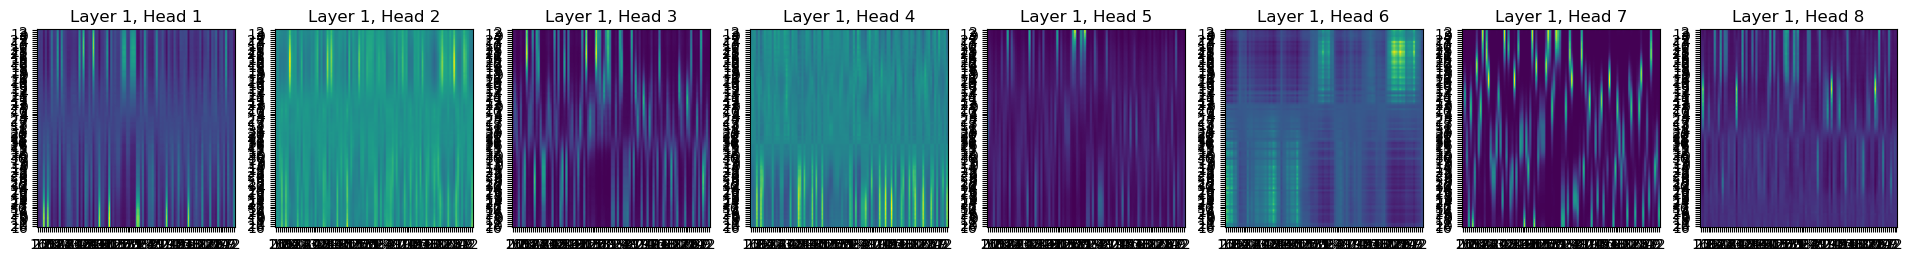

In [25]:
plot_attention_maps(data_input, attention_maps, idx=0)


In [26]:
# Transformations applied on each image => bring them into a numpy array
DATA_MEANS = np.array([0.49139968, 0.48215841, 0.44653091])
DATA_STD = np.array([0.24703223, 0.24348513, 0.26158784])
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - DATA_MEANS) / DATA_STD
    return img

# We need to stack the batch elements
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

test_transform = image_to_numpy
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      image_to_numpy
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for training and validation
train_loader = data.DataLoader(train_set,
                               batch_size=128,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=numpy_collate,
                               num_workers=8,
                               persistent_workers=True)
val_loader   = data.DataLoader(val_set,
                               batch_size=128,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate,
                               num_workers=4,
                               persistent_workers=True)
test_loader  = data.DataLoader(test_set,
                               batch_size=128,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate,
                               num_workers=4,
                               persistent_workers=True)

100%|██████████| 170498071/170498071 [00:13<00:00, 12180463.37it/s]


Extracting ../../data/torchvision/cifar-10-python.tar.gz to ../../data/torchvision
Files already downloaded and verified
Files already downloaded and verified


(-0.5, 137.5, 35.5, -0.5)

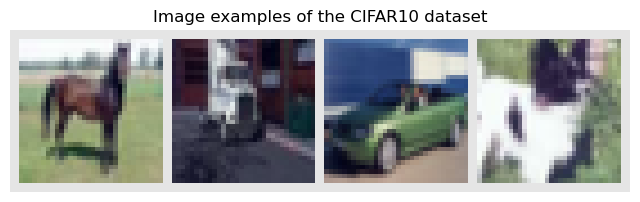

In [27]:
# Visualize some examples
def numpy_to_torch(array):
    array = jax.device_get(array)
    tensor = torch.from_numpy(array)
    tensor = tensor.permute(0, 3, 1, 2)
    return tensor

NUM_IMAGES = 4
CIFAR_images = np.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], axis=0)
img_grid = torchvision.utils.make_grid(numpy_to_torch(CIFAR_images),
                                       nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')

In [28]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, H, W, C]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, H, W, C = x.shape
    x = x.reshape(B, H//patch_size, patch_size, W//patch_size, patch_size, C)
    x = x.transpose(0, 1, 3, 2, 4, 5)    # [B, H', W', p_H, p_W, C]
    x = x.reshape(B, -1, *x.shape[3:])   # [B, H'*W', p_H, p_W, C]
    if flatten_channels:
        x = x.reshape(B, x.shape[1], -1) # [B, H'*W', p_H*p_W*C]
    return x

In [29]:
print(img_to_patch(CIFAR_images, patch_size=8, flatten_channels=False).shape)
print(img_to_patch(CIFAR_images, patch_size=8, flatten_channels=True).shape)

(4, 16, 8, 8, 3)
(4, 16, 192)


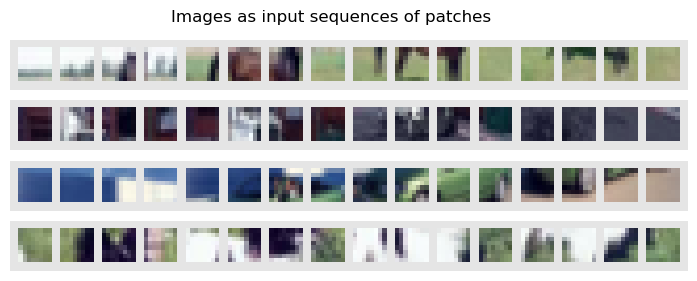

In [30]:
img_patches = img_to_patch(CIFAR_images, patch_size=8, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(numpy_to_torch(img_patches[i]),
                                           nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

In [31]:
class AttentionBlock(nn.Module):
    embed_dim : int   # Dimensionality of input and attention feature vectors
    hidden_dim : int  # Dimensionality of hidden layer in feed-forward network
    num_heads : int   # Number of heads to use in the Multi-Head Attention block
    dropout_prob : float = 0.0  # Amount of dropout to apply in the feed-forward network

    def setup(self):
        self.attn = nn.MultiHeadDotProductAttention(num_heads=self.num_heads)
        self.linear = [
            nn.Dense(self.hidden_dim),
            nn.gelu,
            nn.Dropout(self.dropout_prob),
            nn.Dense(self.embed_dim)
        ]
        self.layer_norm_1 = nn.LayerNorm()
        self.layer_norm_2 = nn.LayerNorm()
        self.dropout = nn.Dropout(self.dropout_prob)

    def __call__(self, x, train=True):
        inp_x = self.layer_norm_1(x)
        attn_out = self.attn(inputs_q=inp_x, inputs_kv=inp_x)
        x = x + self.dropout(attn_out, deterministic=not train)

        linear_out = self.layer_norm_2(x)
        for l in self.linear:
            linear_out = l(linear_out) if not isinstance(l, nn.Dropout) else l(linear_out, deterministic=not train)
        x = x + self.dropout(linear_out, deterministic=not train)
        return x

In [32]:
## Test AttentionBlock implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create attention block
attnblock = AttentionBlock(embed_dim=128, hidden_dim=512, num_heads=4, dropout_prob=0.1)
# Initialize parameters of attention block with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = attnblock.init({'params': init_rng, 'dropout': dropout_init_rng}, x, True)['params']
print(count_params(params))

# Apply encoder block with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
out = attnblock.apply({'params': params}, x, train=True, rngs={'dropout': dropout_apply_rng})
print('Out', out.shape)

del attnblock, params

198272
Out (3, 16, 128)


In [33]:
class VisionTransformer(nn.Module):
    embed_dim : int     # Dimensionality of input and attention feature vectors
    hidden_dim : int    # Dimensionality of hidden layer in feed-forward network
    num_heads : int     # Number of heads to use in the Multi-Head Attention block
    num_channels : int  # Number of channels of the input (3 for RGB)
    num_layers : int    # Number of layers to use in the Transformer
    num_classes : int   # Number of classes to predict
    patch_size : int    # Number of pixels that the patches have per dimension
    num_patches : int   # Maximum number of patches an image can have
    dropout_prob : float = 0.0  # Amount of dropout to apply in the feed-forward network

    def setup(self):
        # Layers/Networks
        self.input_layer = nn.Dense(self.embed_dim)
        self.transformer = [AttentionBlock(self.embed_dim,
                                           self.hidden_dim,
                                           self.num_heads,
                                           self.dropout_prob) for _ in range(self.num_layers)]
        self.mlp_head = nn.Sequential([
            nn.LayerNorm(),
            nn.Dense(self.num_classes)
        ])
        self.dropout = nn.Dropout(self.dropout_prob)

        # Parameters/Embeddings
        self.cls_token = self.param('cls_token',
                                    nn.initializers.normal(stddev=1.0),
                                    (1, 1, self.embed_dim))
        self.pos_embedding = self.param('pos_embedding',
                                        nn.initializers.normal(stddev=1.0),
                                        (1, 1+self.num_patches, self.embed_dim))


    def __call__(self, x, train=True):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, axis=0)
        x = jnp.concatenate([cls_token, x], axis=1)
        x = x + self.pos_embedding[:,:T+1]

        # Apply Transforrmer
        x = self.dropout(x, deterministic=not train)
        for attn_block in self.transformer:
            x = attn_block(x, train=train)

        # Perform classification prediction
        cls = x[:, 0]
        out = self.mlp_head(cls)
        return out

In [34]:
## Test VisionTransformer implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (5, 32, 32, 3))
# Create vision transformer
visntrans = VisionTransformer(embed_dim=128,
                              hidden_dim=512,
                              num_heads=4,
                              num_channels=3,
                              num_layers=6,
                              num_classes=10,
                              patch_size=4,
                              num_patches=64,
                              dropout_prob=0.1)
# Initialize parameters of the Vision Transformer with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = visntrans.init({'params': init_rng, 'dropout': dropout_init_rng}, x, True)['params']
print(count_params(params))

# Apply encoder block with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
out = visntrans.apply({'params': params}, x, train=True, rngs={'dropout': dropout_apply_rng})
print('Out', out.shape)

del visntrans, params

1205898
Out (5, 10)


In [35]:
from collections import defaultdict
class TrainerModule:

    def __init__(self, exmp_imgs, lr=1e-3, weight_decay=0.01, seed=42, **model_hparams):
        """
        Module for summarizing all training functionalities for classification on CIFAR10.

        Inputs:
            exmp_imgs - Example imgs, used as input to initialize the model
            lr - Learning rate of the optimizer to use
            weight_decay - Weight decay to use in the optimizer
            seed - Seed to use in the model initialization
        """
        super().__init__()
        self.lr = lr
        self.weight_decay = weight_decay
        self.seed = seed
        self.rng = jax.random.PRNGKey(self.seed)
        # Create empty model. Note: no parameters yet
        self.model = VisionTransformer(**model_hparams)
        # Prepare logging
        self.logger = SummaryWriter()
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model(exmp_imgs)

    def create_functions(self):
        # Function to calculate the classification loss and accuracy for a model
        def calculate_loss(params, rng, batch, train):
            imgs, labels = batch
            rng, dropout_apply_rng = random.split(rng)
            logits = self.model.apply({'params': params},
                                      imgs,
                                      train=train,
                                      rngs={'dropout': dropout_apply_rng})
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            acc = (logits.argmax(axis=-1) == labels).mean()
            return loss, (acc, rng)
        # Training function
        def train_step(state, rng, batch):
            loss_fn = lambda params: calculate_loss(params, rng, batch, train=True)
            # Get loss, gradients for loss, and other outputs of loss function
            (loss, (acc, rng)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            # Update parameters and batch statistics
            state = state.apply_gradients(grads=grads)
            return state, rng, loss, acc
        # Eval function
        def eval_step(state, rng, batch):
            # Return the accuracy for a single batch
            _, (acc, rng) = calculate_loss(state.params, rng, batch, train=False)
            return rng, acc
        # jit for efficiency
        self.train_step = jax.jit(train_step)
        self.eval_step = jax.jit(eval_step)

    def init_model(self, exmp_imgs):
        # Initialize model
        self.rng, init_rng, dropout_init_rng = random.split(self.rng, 3)
        self.init_params = self.model.init({'params': init_rng, 'dropout': dropout_init_rng},
                                           exmp_imgs,
                                           train=True)['params']
        self.state = None

    def init_optimizer(self, num_epochs, num_steps_per_epoch):
        # We decrease the learning rate by a factor of 0.1 after 60% and 85% of the training
        lr_schedule = optax.piecewise_constant_schedule(
            init_value=self.lr,
            boundaries_and_scales=
                {int(num_steps_per_epoch*num_epochs*0.99): 0.1,
                 int(num_steps_per_epoch*num_epochs*1.00): 0.1}
        )
        optimizer = optax.chain(
            # optax.clip_by_global_norm(1.0),  # Clip gradients at norm 1
            # optax.adamw(lr_schedule, weight_decay=self.weight_decay),
            optax.adabelief(self.lr)
        )
        # Initialize training state
        self.state = train_state.TrainState.create(
                                       apply_fn=self.model.apply,
                                       params=self.init_params if self.state is None else self.state.params,
                                       tx=optimizer)

    def train_model(self, train_loader, val_loader, num_epochs=200):
        # Train model for defined number of epochs
        # We first need to create optimizer and the scheduler for the given number of epochs
        self.init_optimizer(num_epochs, len(train_loader))
        # Track best eval accuracy
        best_eval = 0.0
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(epoch=epoch_idx)
            if epoch_idx % 2 == 0:
                eval_acc = self.eval_model(val_loader)
                self.logger.add_scalar('val/acc', eval_acc, global_step=epoch_idx)
                if eval_acc >= best_eval:
                    best_eval = eval_acc
                self.logger.flush()

    def train_epoch(self, epoch):
        # Train model for one epoch, and log avg loss and accuracy
        metrics = defaultdict(list)
        for batch in train_loader:
            self.state, self.rng, loss, acc = self.train_step(self.state, self.rng, batch)
            metrics['loss'].append(loss)
            metrics['acc'].append(acc)
        for key in metrics:
            avg_val = np.stack(jax.device_get(metrics[key])).mean()
            self.logger.add_scalar('train/'+key, avg_val, global_step=epoch)

    def eval_model(self, data_loader):
        # Test model on all images of a data loader and return avg loss
        correct_class, count = 0, 0
        for batch in data_loader:
            self.rng, acc = self.eval_step(self.state, self.rng, batch)
            correct_class += acc * batch[0].shape[0]
            count += batch[0].shape[0]
        eval_acc = (correct_class / count).item()
        return eval_acc


In [36]:
def train_model(*args, num_epochs=200, **kwargs):
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(*args, **kwargs)
    trainer.train_model(train_loader, val_loader, num_epochs=num_epochs)

    # Test trained model
    val_acc = trainer.eval_model(val_loader)
    test_acc = trainer.eval_model(test_loader)
    return trainer, {'val': val_acc, 'test': test_acc}

In [37]:
model, results = train_model(exmp_imgs=next(iter(train_loader))[0],
                             embed_dim=256,
                             hidden_dim=512,
                             num_heads=8,
                             num_layers=6,
                             patch_size=4,
                             num_channels=3,
                             num_patches=64,
                             num_classes=10,
                             dropout_prob=0.2,
                             lr=5e-4)
print("ViT results", results)

  0%|          | 0/200 [00:00<?, ?it/s]

ViT results {'val': 0.7816000580787659, 'test': 0.7720000147819519}
